# Building a Plagiarism detection model with Keras

## The dataset

The PAN-PC-10 can be used to evaluate the following retrieval task:

Plagiarism Detection. 
* Given a set of suspicious documents and a set of source documents, the task is 
to decide if given suspicious document is original 

The PAN-PC-10 contains documents in which artificial plagiarism has been inserted automatically as well as documents in which simulated plagiarism has been inserted manually. The former have been constructed using a so-called random plagiarist, a computer program which constructs plagiarism according to a number of parameters, while the latter have been obtained with crowdsourcing via Amazon's Mechanical Turk.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# it is much faster than loading unzipped images from drive https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf
!unrar x -Y "/content/drive/MyDrive/pan-plagiarism-corpus-2010-images.rar" "./pan-plagiarism-corpus-2010-images/"

Výstup streamovania bol skrátený na tento počet posledných riadkov: 5000.
Extracting  ./pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images/suspicious-document10927.txt.preprocessed.png      68%  OK 
Extracting  ./pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images/suspicious-document10928.txt.preprocessed.png      68%  OK 
Extracting  ./pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images/suspicious-document10929.txt.preprocessed.png      68%  OK 
Extracting  ./pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images/suspicious-document10930.txt.preprocessed.png      68%  OK 
Extracting  ./pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images/suspicious-document10931.txt.preprocessed.png      68%  OK 
Extracting  ./pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images/suspicious-document10932.txt.preprocessed.png      68%  OK 
Extracting  ./pan-pl

In [ ]:
dataset_folder_name = './pan-plagiarism-corpus-2010-images/pan-plagiarism-corpus-2010-images'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 200

dataset_dict = {
    'plagiarism_id': {
        0: 'no_plagiarism',
        1: 'plagiarism'
    }
}

dataset_dict['plagiarism_alias'] = dict((g, i) for i, g in dataset_dict['plagiarism_id'].items())

In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The following code aims to create pandas dataframe with necessary information.

In [ ]:
def make_absolute_path(x):
	return dataset_folder_name +"/"+ x
	
df = pd.read_csv("/content/drive/MyDrive/out.csv")
df['file'] = df['file'].apply(make_absolute_path)
df

,file,originality
0,./pan-plagiarism-corpus-2010-images/pan-plagia...,plagiarism
1,./pan-plagiarism-corpus-2010-images/pan-plagia...,plagiarism
2,./pan-plagiarism-corpus-2010-images/pan-plagia...,no_plagiarism
3,./pan-plagiarism-corpus-2010-images/pan-plagia...,no_plagiarism
4,./pan-plagiarism-corpus-2010-images/pan-plagia...,plagiarism
...,...,...
15920,./pan-plagiarism-corpus-2010-images/pan-plagia...,plagiarism
15921,./pan-plagiarism-corpus-2010-images/pan-plagia...,plagiarism
15922,./pan-plagiarism-corpus-2010-images/pan-plagia...,no_plagiarism
15923,./pan-plagiarism-corpus-2010-images/pan-plagia...,plagiarism


# Data visualization

* Plagiarism: 0 - plagiarism, 1 - no_plagiarism 

In [ ]:
import plotly.graph_objects as go
## calculating distributions
plagiarism_dist = df['originality'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Plagiarism distribution

In [ ]:
ditribution_plot(x=plagiarism_dist.index, y=plagiarism_dist.values, name='Plagiarism Distribution')

# Data preparation

Data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model.

In [ ]:
from keras.utils import to_categorical
from PIL import Image

class PlagiarismDataGenerator():

    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['plagiarism_id'] = self.df['originality'].map(lambda plagiarism: dataset_dict['plagiarism_alias'][plagiarism])

        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        # images were saved as RGBA by mistake, model can work only with RGB
        im = im.convert('RGB')
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        # arrays to store our batched data
        images, originalitys = [], []
        while True:
            for idx in image_idx:
                suspicious_document = self.df.iloc[idx]

                originality = suspicious_document['plagiarism_id']
                file = suspicious_document['file']
                
                im = self.preprocess_image(file)
                
                originalitys.append(to_categorical(originality, len(dataset_dict['plagiarism_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), np.array(originalitys)
                    images,  originalitys = [], []
                    
            if not is_training:
                break

    # iteration error for same reason
    def generate_images_for_clustering(self, image_idx, is_training, batch_size=16):
        # arrays to store our batched data
        images, originalitys = [], []
        while True:
            for idx in image_idx:
                suspicious_document = self.df.iloc[idx]

                originality = suspicious_document['plagiarism_id']
                file = suspicious_document['file']
                
                im = self.preprocess_image(file)
                
                originalitys.append(to_categorical(originality, len(dataset_dict['plagiarism_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), np.array(originalitys)
                    images,  originalitys = [], []
                    
            # if not is_training:
            #     break
                
data_generator = PlagiarismDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
# just to check data distribution between train, valid, test
# train and valid are used during model fitting
# test used for predictions on unseen data
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))

7802
3345
4778


## Building our model

The default structure for our convolutional layers is based on a Conv2D layer with a ReLU activation, followed by a BatchNormalization layer, a MaxPooling and finally a Dropout layer. Each of this default layer is then followed by the final layer, composed by a Dense layer.

In [ ]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class PlagiarismOutputModel():

    def make_default_hidden_layers(self, inputs):
        # Used to generate a default set of hidden layers. The structure used in this network is defined as:
        # Conv2D -> BatchNormalization -> Pooling -> Dropout
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.1)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)

        return x

    def build_plagiarism_branch(self, inputs, num_plagiarism=2):
        # Used to build the plagiarism branch of our plagiarism recognition network.
        # This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        # followed by the Dense output layer.        
        # x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu", name="vector_layer")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_plagiarism)(x)
        x = Activation("sigmoid", name="plagiarism_output")(x)

        return x

    def assemble_full_model(self, width, height):
        # Used to assemble our model CNN.
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        plagiarism_branch = self.build_plagiarism_branch(inputs)
        model = Model(inputs = inputs,
                     outputs = [plagiarism_branch],
                     name="plagiarism_net")
        return model
    
model = PlagiarismOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)

*Let*'s give a look into our model structure and summary, to have a better understanding of what we are building. Also to check for early errors.

In [ ]:
# It can be used to reconstruct the model identically.

# from tensorflow import keras
# model = keras.models.load_model("/content/drive/MyDrive/model_checkpoint_plagiarism")


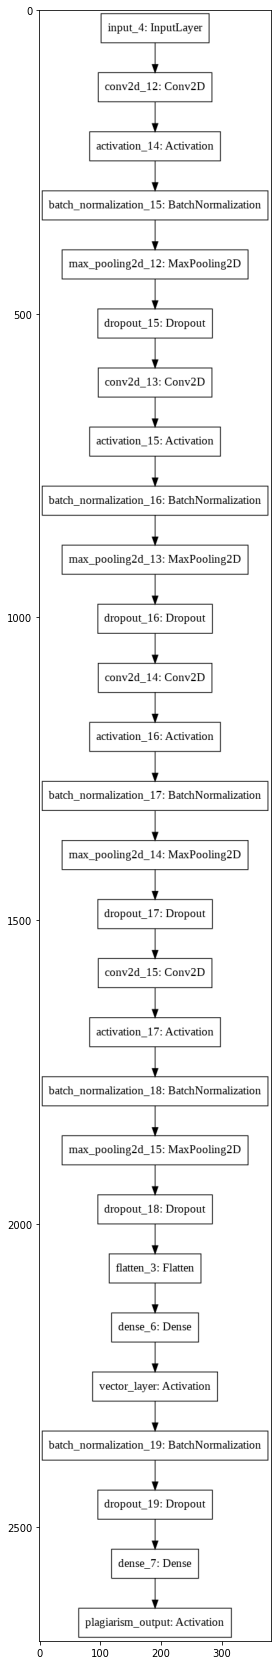

In [ ]:
%matplotlib inline

from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='/content/drive/MyDrive/model.png')
img = mpimg.imread('/content/drive/MyDrive/model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [ ]:
model.summary()

Model: "plagiarism_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
activation_14 (Activation)   (None, 200, 200, 16)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 66, 66, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 66, 66, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 66, 66, 32)     

## Training our model

Now it's time to train our model, once we already have everything done. But before doing it, we need to compile our model. For this step, let's use a learning rate of 0.0004 and an Adam optimizer. 

When building our optimizer, let's use a decay based on the learning rate divided by the number of epochs, so we will slowly be decreasing our learning rate over the epochs.

In [ ]:
from keras.optimizers import Adam, SGD

init_lr = 1e-4
epochs = 150

# opt = Adam(lr=init_lr, decay=init_lr / epochs)
opt = SGD(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss= 'binary_crossentropy',
              loss_weights= 1,
              metrics= 'accuracy')

And now let's train our model with a batch size of 64 for both valid and train sets. We will be using a ModelCheckpoint callback in order to save the model on disk at the end of each epoch.

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/model_checkpoint_plagiarism_sgd", monitor='val_loss')
]

# history = model.fit(train_gen,
#                     steps_per_epoch=10,
#                     epochs=epochs,
#                     callbacks=callbacks,
#                     validation_data=valid_gen,
#                     validation_steps=10)

# in fastaiv2 fit one cycle was used, in keras is just some weird libraries with plenty of issues
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/150
121/121 [==============================] - ETA: 0s - loss: 0.7795 - accuracy: 0.6082WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_checkpoint_plagiarism_sgd/assets
121/121 [==============================] - 45s 368ms/step - loss: 0.7795 - accuracy: 0.6082 - val_loss: 0.7301 - val_accuracy: 0.6448
Epoch 2/150
121/121 [==============================] - 36s 297ms/step - loss: 0.7692 - accuracy: 0.6142 - val_loss: 0.7604 - val_accuracy: 0.6457
Epoch 3/150
121/121 [==============================] - 

In [ ]:
# model.save("/content/drive/MyDrive/my_model_plagiarism")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model_plagiarism/assets


### Plagiarism accuracy

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))

fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for train plagiarism feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_train_plagiarism.html', include_plotlyjs='cdn')

fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Validation'))

fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for validation plagiarism feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_val_plagiarism.html', include_plotlyjs='cdn')

fig.show()

<Figure size 432x288 with 0 Axes>

### Overall loss

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))


fig.update_layout(height=450, 
                  width=600,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.write_html('overall_loss.html', include_plotlyjs='cdn')

fig.show()

## Evaluating model on the test set

In order to assess how our model performs on the test set, let's use our data generator, but this time using the test indexes. We will then call the predict method from our trained model, which will output the predictions for the test set.

Test set means data that was never seen by my NN before

In [ ]:
# Keras get model layer
# https://stackoverflow.com/questions/53280916/getting-vector-obtained-in-the-last-layer-of-cnn-before-softmax-layer

In [ ]:
test_batch_size = 64
test_generator = data_generator.generate_images_for_clustering(test_idx, is_training=False, batch_size=test_batch_size)
plagiarism_pred = model.predict(test_generator, steps=len(test_idx)//test_batch_size)
print(plagiarism_pred)

[[0.67921084 0.26925036]
 [0.65054685 0.3055666 ]
 [0.6941073  0.33415627]
 ...
 [0.6994229  0.21579982]
 [0.65169775 0.29952627]
 [0.64249337 0.31989053]]


# Clustering 
Clustering can be done using different techniques like K-means clustering, Mean Shift clustering, DB Scan clustering, Hierarchical clustering etc. 

We will try to cluster suspicious documents into plagiarism photos and originality photos. For this purpose, we can derive the image vector from our CNN model. We can remove the final layer of our CNN and pull the 128 sized vector. Once we have the vectors, we apply KMeans clustering over the datapoints.

https://ai-mrkogao.github.io/reinforcement%20learning/clusteringkeras/

In [ ]:
# Obtaining image vector for clustering
vector_cluster_model = keras.Model(inputs=model.input, outputs= model.get_layer("vector_layer").output)
vector_cluster_model.summary()
pred_vector_cluster_model = vector_cluster_model.predict(test_generator, steps = len(test_idx)//test_batch_size) 
print(pred_vector_cluster_model.shape) 

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 66, 66, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 32)       

In [ ]:
# https://towardsdatascience.com/using-k-means-clustering-for-image-segregation-fd80bea8412d
from sklearn.cluster import KMeans
import os, glob, shutil

# We know that we have only two classes 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
k = 2
kmodel = KMeans(n_clusters = k, n_jobs=-1, random_state=128)

kmodel.fit(pred_vector_cluster_model)
kmodel_pred = kmodel.predict(pred_vector_cluster_model)
print(len(kmodel_pred))
print(kmodel_pred)


4736
[1 1 0 ... 0 0 1]


# Plagiarism predictions using CNN only

Let's iterate one time over all our test samples, in order to have their labels into a single list. We will also extract the arg max of each record, in order to retrieve the top predictions and ground truths.

In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, plagiarism_true = [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    plagiarism_true.extend(labels)
    
plagiarism_true = np.array(plagiarism_true)

plagiarism_true = plagiarism_true.argmax(axis=-1)
plagiarism_pred = plagiarism_pred.argmax(axis=-1)

print(plagiarism_true)
print(plagiarism_pred)


[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


##First, we get a look at predictions using K-means clustering



               precision    recall  f1-score   support

no_plagiarism       0.65      0.64      0.65      3050
   plagiarism       0.36      0.37      0.37      1686

     accuracy                           0.55      4736
    macro avg       0.51      0.51      0.51      4736
 weighted avg       0.55      0.55      0.55      4736



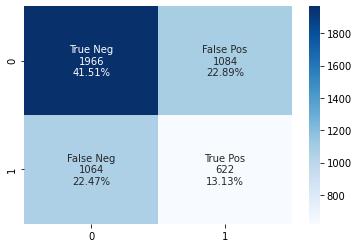

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

plagiarism_cr = classification_report(plagiarism_true, kmodel_pred, target_names=dataset_dict['plagiarism_alias'].keys())

print(plagiarism_cr)

cf_matrix = confusion_matrix(plagiarism_true, kmodel_pred )


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Then, we get a look at predictions using CNN only

               precision    recall  f1-score   support

no_plagiarism       0.64      1.00      0.78      3050
   plagiarism       0.00      0.00      0.00      1686

     accuracy                           0.64      4736
    macro avg       0.32      0.50      0.39      4736
 weighted avg       0.41      0.64      0.50      4736



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



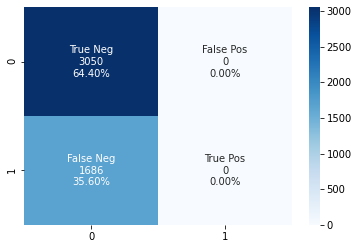

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

plagiarism_cr = classification_report(plagiarism_true, plagiarism_pred, target_names=dataset_dict['plagiarism_alias'].keys())

print(plagiarism_cr)

cf_matrix = confusion_matrix(plagiarism_true, plagiarism_pred )

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Example of predictions using CNN only

We cannot really check the correctness of predictions just by looking at the pictures

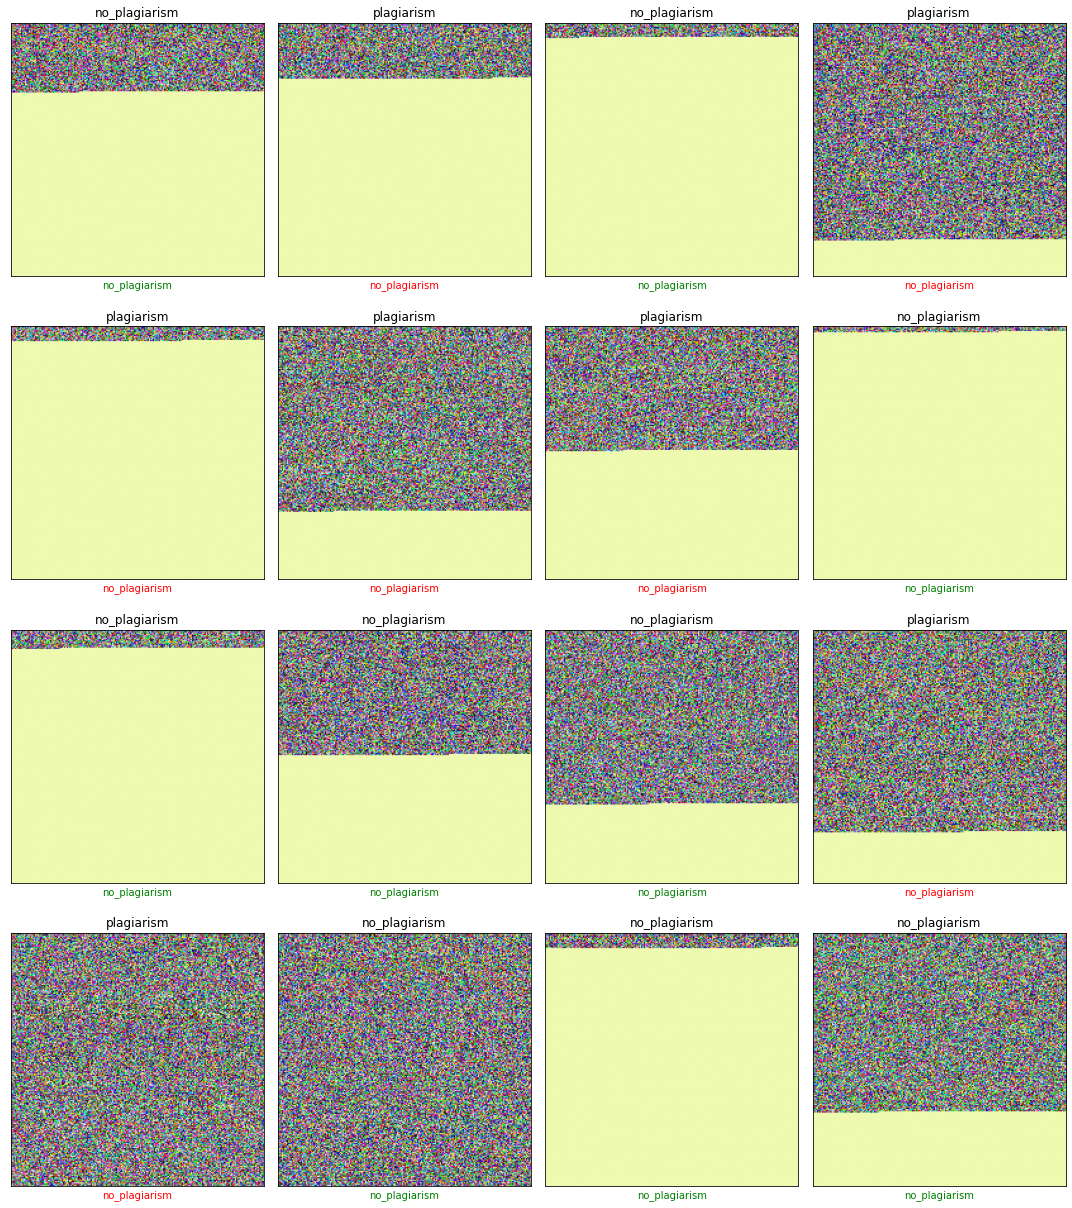

In [ ]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_plagiarism_pred = plagiarism_pred[img_idx]
    cur_plagiarism_true = plagiarism_true[img_idx]
    
    if cur_plagiarism_pred == cur_plagiarism_true:
        ax.xaxis.label.set_color('green')
    elif cur_plagiarism_pred != cur_plagiarism_true:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('{}'.format(dataset_dict['plagiarism_id'][plagiarism_pred[img_idx]]))
    ax.set_title('{}'.format(dataset_dict['plagiarism_id'][plagiarism_true[img_idx]]))

    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/preds_plagiarism.png')